# Домашнее задание  № 5. Матричные разложения/Тематическое моделирование

In [59]:
! pip install pyLDAvis

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 1.7 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 kB 1.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 kB 1.8 MB/s eta 0:00:00a 0:00:01
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136882 sha256=3943251e17c9951ce048549b7931850d599c15395c0baa3ba0b69e76dae99224
  Stored in directory: /Users/tbkazakova/Library/Caches/pip/wheels/1f/ef/46/1dc1c1e5d8ff2f3b44

In [6]:
! pip install seaborn

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 1.0 MB/s eta 0:00:0000:0100:01
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python3.9 -m pip install --upgrade pip


### Задание № 1 (4 балла)

Попробуйте матричные разложения с 4 классификаторами - SGDClassifier, KNeighborsClassifier,  RandomForest, ExtraTreesClassifier (про него подробнее почитайте в документации, он похож на RF). Используйте и NMF и SVD. Сравните результаты на кросс-валидации и выберите лучшее сочетание.

В итоге у вас должно получиться, как минимум 8 моделей (два разложения на каждый классификатор). Используйте 1 и те же параметры кросс-валидации. Параметры векторизации, параметры K в матричных разложениях, параметры классификаторов могут быть разными между экспериментами.

Можете взять поменьше данных, если все будет обучаться слишком долго (не ставьте параметр K слишком большим в NMF, иначе точно будет слишком долго)

In [7]:
import pandas as pd
import numpy as np
from pymorphy2 import MorphAnalyzer
from collections import Counter
from string import punctuation
from razdel import tokenize as razdel_tokenize
from IPython.display import Image
from IPython.core.display import HTML 
from sklearn.decomposition import TruncatedSVD, NMF, PCA, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold
from matplotlib import pyplot as plt
import seaborn as sns
morph = MorphAnalyzer()

In [15]:
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [62]:
import gensim
import pyLDAvis.gensim_models

In [8]:
# добавим лемматизацию
def normalize(text):
    normalized_text = [word.text.strip(punctuation) for word \
                                                            in razdel_tokenize(text)]
    normalized_text = [word.lower() for word in normalized_text if word and len(word) < 20 ]
    normalized_text = [morph.parse(word)[0].normal_form for word in normalized_text]
    return ' '.join(normalized_text)

In [9]:
data = pd.read_csv('avito_category_classification.csv')

In [10]:
data['description_norm'] = data['description'].apply(normalize)

In [25]:
pipeline_nmf_SGDClf = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', NMF(100)),
    ('clf', SGDClassifier(max_iter=1000, tol=1e-3))
])

pipeline_svd_SGDClf = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('svd', TruncatedSVD(500)),
    ('clf', SGDClassifier(max_iter=1000, tol=1e-3))
])

pipeline_nmf_KNClf = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', NMF(100)),
    ('clf', KNeighborsClassifier(n_neighbors=3))
])

pipeline_svd_KNClf = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('svd', TruncatedSVD(500)),
    ('clf', KNeighborsClassifier(n_neighbors=3))
])

pipeline_nmf_RFClf = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', NMF(100)),
    ('clf', RandomForestClassifier(max_depth=2, random_state=0))
])

pipeline_svd_RFClf = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('svd', TruncatedSVD(500)),
    ('clf', RandomForestClassifier(max_depth=2, random_state=0))
])

pipeline_nmf_ETClf = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', NMF(100)),
    ('clf', ExtraTreesClassifier(n_estimators=100, random_state=0))
])

pipeline_svd_ETClf = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('svd', TruncatedSVD(500)),
    ('clf', ExtraTreesClassifier(n_estimators=100, random_state=0))
])

In [26]:
def eval_table(X, y, pipeline, N=6):
    # зафиксируем порядок классов
    labels = list(set(y))
    
    # метрики отдельных фолдов будет хранить в табличке
    fold_metrics = pd.DataFrame(index=labels)
    # дополнительно также соберем таблицу ошибок
    errors = np.zeros((len(labels), len(labels)))
    
    # создаем стратегию кросс-валидации
    # shuffle=True (перемешивание) - часто критично важно указать
    # т.к. данные могут быть упорядочены и модель на этом обучится
    kfold = StratifiedKFold(n_splits=N, shuffle=True, )
    
    for i, (train_index, test_index) in enumerate(kfold.split(X, y)):
        # fit-predict как и раньше, но сразу пайплайном
        pipeline.fit(X[train_index], y[train_index])
        preds = pipeline.predict(X[test_index])
        
        # записываем метрику и индекс фолда
        fold_metrics[f'precision_{i}'] = precision_score(y[test_index], preds, labels=labels, average=None)
        fold_metrics[f'recall_{i}'] = recall_score(y[test_index], preds, labels=labels, average=None)
        fold_metrics[f'f1_{i}'] = f1_score(y[test_index], preds, labels=labels, average=None)
        errors += confusion_matrix(y[test_index], preds, labels=labels, normalize='true')
    
    # таблица для усредненных значений
    # тут мы берем колонки со значениями и усредняем их
    # часто также все метрики сразу суммируют и в конце просто делят на количество фолдов
    # но мы тут помимо среднего также хотим посмотреть на стандартное отклонение
    # чтобы понять как сильно варьируются оценки моделей
    result = pd.DataFrame(index=labels)
    result['precision'] = fold_metrics[[f'precision_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['precision_std'] = fold_metrics[[f'precision_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result['recall'] = fold_metrics[[f'recall_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['recall_std'] = fold_metrics[[f'recall_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result['f1'] = fold_metrics[[f'f1_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['f1_std'] = fold_metrics[[f'f1_{i}' for i in range(N)]].std(axis=1).round(2)
     # добавим одну колонку со средним по всем классам
    result.loc['mean'] = result.mean().round(2)
    # проценты ошибок просто усредняем
    errors /= N
    
    return result, errors

In [38]:
metrics_nmf_SGDClf, errors_nmf_SGDClf = eval_table(data['description_norm'], data['category_name'],
                                                   pipeline_nmf_SGDClf)
metrics_svd_SGDClf, errors_svd_SGDClf = eval_table(data['description_norm'], data['category_name'],
                                                   pipeline_svd_SGDClf)
metrics_nmf_KNClf, errors_nmf_KNClf = eval_table(data['description_norm'], data['category_name'],
                                                   pipeline_nmf_KNClf)
metrics_svd_KNClf, errors_svd_KNClf = eval_table(data['description_norm'], data['category_name'],
                                                   pipeline_svd_KNClf)
metrics_nmf_RFClf, errors_nmf_RFClf = eval_table(data['description_norm'], data['category_name'],
                                                   pipeline_nmf_RFClf)
metrics_svd_RFClf, errors_svd_RFClf = eval_table(data['description_norm'], data['category_name'],
                                                  pipeline_svd_RFClf)
metrics_nmf_ETClf, errors_nmf_ETClf = eval_table(data['description_norm'], data['category_name'],
                                                   pipeline_nmf_ETClf)
metrics_svd_ETClf, errors_svd_ETClf = eval_table(data['description_norm'], data['category_name'],
                                                 pipeline_svd_ETClf)

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Pr

In [39]:
metrics_nmf_SGDClf

precision  precision_std  recall  recall_std  \
Детская одежда и обувь           0.59           0.23    0.65        0.22   
Телефоны                         0.83           0.17    0.43        0.29   
Квартиры                         0.73           0.19    0.89        0.12   
Мебель и интерьер                0.57           0.21    0.39        0.17   
Предложение услуг                0.78           0.11    0.26        0.09   
Ремонт и строительство           0.21           0.24    0.11        0.16   
Автомобили                       0.73           0.18    0.69        0.21   
Одежда, обувь, аксессуары        0.59           0.08    0.65        0.19   
Товары для детей и игрушки       0.75           0.33    0.35        0.22   
Бытовая техника                  0.41           0.15    0.07        0.03   
mean                             0.62           0.19    0.45        0.17   

                              f1  f1_std  
Детская одежда и обувь      0.55    0.08  
Телефоны                    0.48    0.24  
Квартиры                    0.78    0.12  
Мебель и интерьер           0.41    0.05  
Предложение услуг           0.38    0.09  
Ремонт и строительство      0.13    0.18  
Автомобили                  0.67    0.09  
Одежда, обувь, аксессуары   0.60    0.07  
Товары для детей и игрушки  0.37    0.09  
Бытовая техника             0.11    0.04  
mean                        0.45    0.11

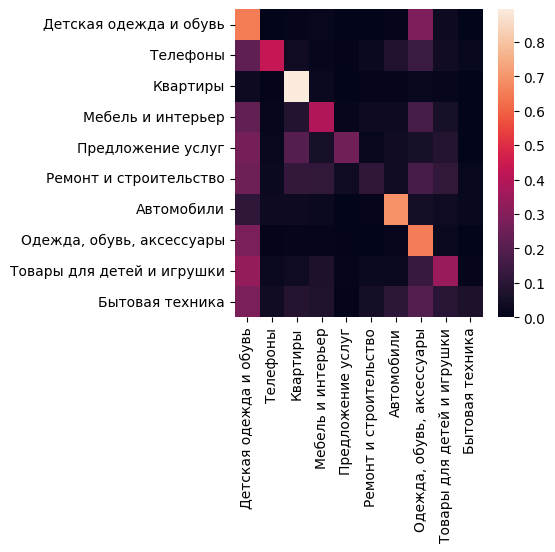

In [40]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_nmf_SGDClf, xticklabels=metrics_nmf_SGDClf.index.tolist()[:-1], 
            yticklabels=metrics_nmf_SGDClf.index.tolist()[:-1])
plt.show()

In [41]:
metrics_svd_SGDClf

precision  precision_std  recall  recall_std  \
Детская одежда и обувь           0.73           0.03    0.77        0.02   
Телефоны                         0.84           0.06    0.79        0.05   
Квартиры                         0.96           0.03    0.96        0.02   
Мебель и интерьер                0.67           0.08    0.65        0.04   
Предложение услуг                0.79           0.02    0.75        0.05   
Ремонт и строительство           0.65           0.09    0.46        0.09   
Автомобили                       0.87           0.05    0.90        0.03   
Одежда, обувь, аксессуары        0.70           0.03    0.78        0.04   
Товары для детей и игрушки       0.75           0.05    0.65        0.03   
Бытовая техника                  0.63           0.06    0.50        0.06   
mean                             0.76           0.05    0.72        0.04   

                              f1  f1_std  
Детская одежда и обувь      0.75    0.01  
Телефоны                    0.81    0.03  
Квартиры                    0.96    0.02  
Мебель и интерьер           0.66    0.05  
Предложение услуг           0.77    0.03  
Ремонт и строительство      0.54    0.07  
Автомобили                  0.88    0.02  
Одежда, обувь, аксессуары   0.74    0.01  
Товары для детей и игрушки  0.70    0.03  
Бытовая техника             0.55    0.03  
mean                        0.74    0.03

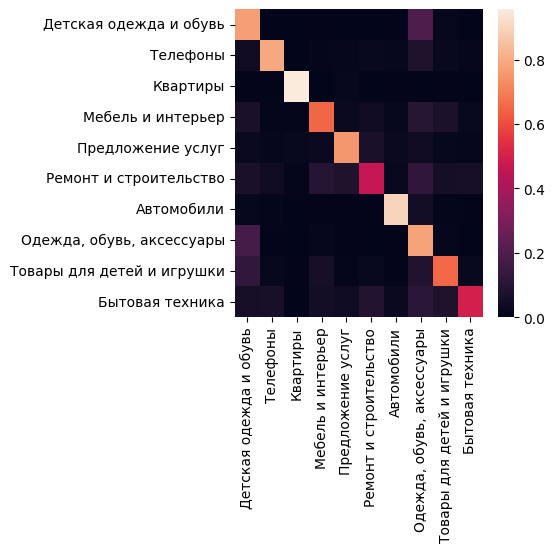

In [42]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_svd_SGDClf, xticklabels=metrics_svd_SGDClf.index.tolist()[:-1], 
            yticklabels=metrics_svd_SGDClf.index.tolist()[:-1])
plt.show()

In [43]:
metrics_nmf_KNClf

precision  precision_std  recall  recall_std  \
Детская одежда и обувь           0.49           0.03    0.57        0.03   
Телефоны                         0.82           0.09    0.49        0.09   
Квартиры                         0.78           0.06    0.84        0.04   
Мебель и интерьер                0.30           0.10    0.28        0.06   
Предложение услуг                0.53           0.04    0.63        0.03   
Ремонт и строительство           0.31           0.08    0.20        0.06   
Автомобили                       0.47           0.02    0.74        0.05   
Одежда, обувь, аксессуары        0.52           0.03    0.47        0.04   
Товары для детей и игрушки       0.51           0.08    0.24        0.06   
Бытовая техника                  0.14           0.05    0.24        0.08   
mean                             0.49           0.06    0.47        0.05   

                              f1  f1_std  
Детская одежда и обувь      0.53    0.03  
Телефоны                    0.61    0.09  
Квартиры                    0.80    0.03  
Мебель и интерьер           0.29    0.08  
Предложение услуг           0.58    0.03  
Ремонт и строительство      0.24    0.07  
Автомобили                  0.57    0.03  
Одежда, обувь, аксессуары   0.49    0.03  
Товары для детей и игрушки  0.33    0.07  
Бытовая техника             0.18    0.06  
mean                        0.46    0.05

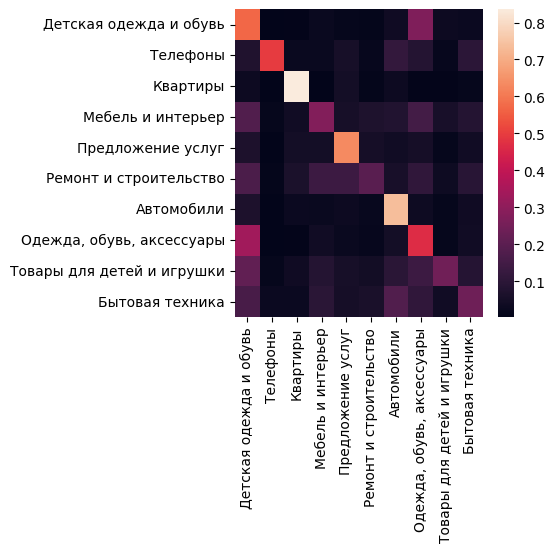

In [44]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_nmf_KNClf, xticklabels=metrics_nmf_KNClf.index.tolist()[:-1], 
            yticklabels=metrics_nmf_KNClf.index.tolist()[:-1])
plt.show()

In [45]:
metrics_svd_KNClf

precision  precision_std  recall  recall_std  \
Детская одежда и обувь           0.46           0.01    0.61        0.05   
Телефоны                         0.79           0.07    0.29        0.05   
Квартиры                         0.90           0.03    0.73        0.03   
Мебель и интерьер                0.31           0.03    0.29        0.05   
Предложение услуг                0.61           0.07    0.52        0.04   
Ремонт и строительство           0.30           0.08    0.14        0.03   
Автомобили                       0.48           0.03    0.65        0.05   
Одежда, обувь, аксессуары        0.49           0.02    0.52        0.03   
Товары для детей и игрушки       0.55           0.10    0.25        0.02   
Бытовая техника                  0.20           0.03    0.37        0.07   
mean                             0.51           0.05    0.44        0.04   

                              f1  f1_std  
Детская одежда и обувь      0.52    0.02  
Телефоны                    0.43    0.06  
Квартиры                    0.81    0.02  
Мебель и интерьер           0.29    0.04  
Предложение услуг           0.56    0.05  
Ремонт и строительство      0.19    0.05  
Автомобили                  0.55    0.03  
Одежда, обувь, аксессуары   0.50    0.02  
Товары для детей и игрушки  0.34    0.04  
Бытовая техника             0.26    0.04  
mean                        0.44    0.04

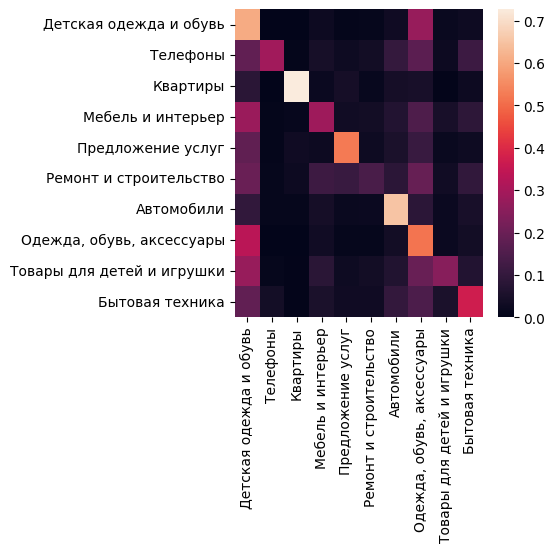

In [46]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_svd_KNClf, xticklabels=metrics_svd_KNClf.index.tolist()[:-1], 
            yticklabels=metrics_svd_KNClf.index.tolist()[:-1])
plt.show()

In [47]:
metrics_nmf_RFClf

precision  precision_std  recall  recall_std  \
Детская одежда и обувь           0.59           0.06    0.59        0.04   
Телефоны                         0.16           0.38    0.02        0.06   
Квартиры                         0.89           0.03    0.84        0.10   
Мебель и интерьер                0.00           0.00    0.00        0.00   
Предложение услуг                0.00           0.00    0.00        0.00   
Ремонт и строительство           0.00           0.00    0.00        0.00   
Автомобили                       0.96           0.04    0.32        0.07   
Одежда, обувь, аксессуары        0.32           0.01    0.84        0.03   
Товары для детей и игрушки       0.47           0.52    0.02        0.03   
Бытовая техника                  0.00           0.00    0.00        0.00   
mean                             0.34           0.10    0.26        0.03   

                              f1  f1_std  
Детская одежда и обувь      0.59    0.02  
Телефоны                    0.04    0.10  
Квартиры                    0.86    0.06  
Мебель и интерьер           0.00    0.00  
Предложение услуг           0.00    0.00  
Ремонт и строительство      0.00    0.00  
Автомобили                  0.48    0.07  
Одежда, обувь, аксессуары   0.46    0.01  
Товары для детей и игрушки  0.04    0.05  
Бытовая техника             0.00    0.00  
mean                        0.25    0.03

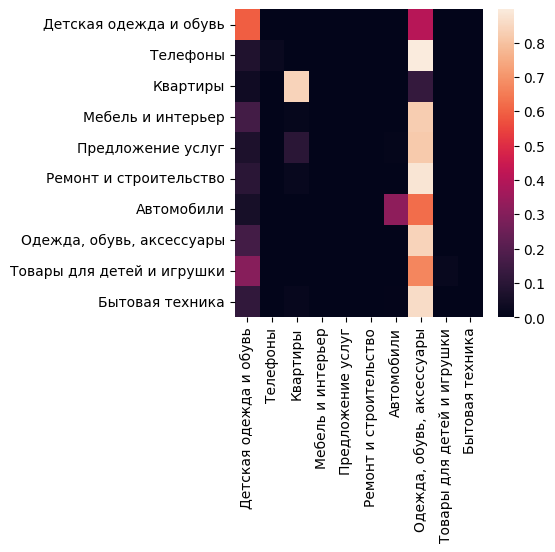

In [48]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_nmf_RFClf, xticklabels=metrics_nmf_RFClf.index.tolist()[:-1], 
            yticklabels=metrics_nmf_RFClf.index.tolist()[:-1])
plt.show()

In [49]:
metrics_svd_RFClf

precision  precision_std  recall  recall_std  \
Детская одежда и обувь           0.30           0.03    0.51        0.05   
Телефоны                         0.00           0.00    0.00        0.00   
Квартиры                         0.91           0.06    0.52        0.12   
Мебель и интерьер                0.00           0.00    0.00        0.00   
Предложение услуг                0.00           0.00    0.00        0.00   
Ремонт и строительство           0.00           0.00    0.00        0.00   
Автомобили                       0.00           0.00    0.00        0.00   
Одежда, обувь, аксессуары        0.37           0.01    0.79        0.05   
Товары для детей и игрушки       0.00           0.00    0.00        0.00   
Бытовая техника                  0.00           0.00    0.00        0.00   
mean                             0.16           0.01    0.18        0.02   

                              f1  f1_std  
Детская одежда и обувь      0.38    0.03  
Телефоны                    0.00    0.00  
Квартиры                    0.66    0.10  
Мебель и интерьер           0.00    0.00  
Предложение услуг           0.00    0.00  
Ремонт и строительство      0.00    0.00  
Автомобили                  0.00    0.00  
Одежда, обувь, аксессуары   0.50    0.02  
Товары для детей и игрушки  0.00    0.00  
Бытовая техника             0.00    0.00  
mean                        0.15    0.02

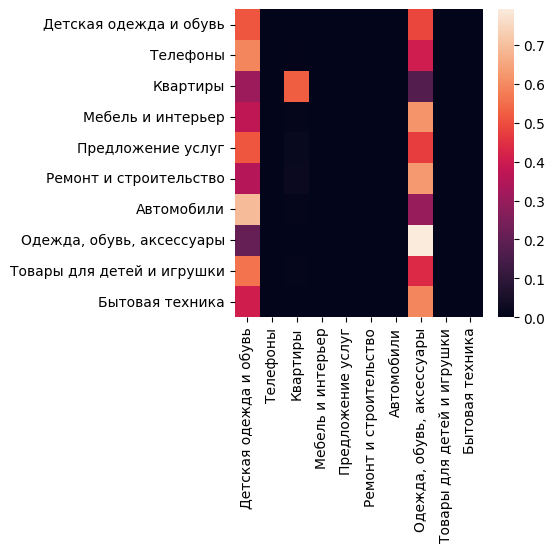

In [50]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_svd_RFClf, xticklabels=metrics_svd_RFClf.index.tolist()[:-1], 
            yticklabels=metrics_svd_RFClf.index.tolist()[:-1])
plt.show()

In [51]:
metrics_nmf_ETClf

precision  precision_std  recall  recall_std  \
Детская одежда и обувь           0.73           0.02    0.75        0.02   
Телефоны                         0.81           0.03    0.79        0.03   
Квартиры                         0.93           0.02    0.97        0.01   
Мебель и интерьер                0.70           0.04    0.54        0.08   
Предложение услуг                0.72           0.03    0.75        0.03   
Ремонт и строительство           0.59           0.05    0.45        0.04   
Автомобили                       0.84           0.03    0.90        0.04   
Одежда, обувь, аксессуары        0.68           0.02    0.78        0.01   
Товары для детей и игрушки       0.73           0.02    0.60        0.02   
Бытовая техника                  0.61           0.10    0.28        0.05   
mean                             0.73           0.04    0.68        0.03   

                              f1  f1_std  
Детская одежда и обувь      0.74    0.02  
Телефоны                    0.80    0.01  
Квартиры                    0.95    0.01  
Мебель и интерьер           0.61    0.06  
Предложение услуг           0.73    0.01  
Ремонт и строительство      0.51    0.03  
Автомобили                  0.87    0.02  
Одежда, обувь, аксессуары   0.73    0.01  
Товары для детей и игрушки  0.66    0.01  
Бытовая техника             0.38    0.05  
mean                        0.70    0.02

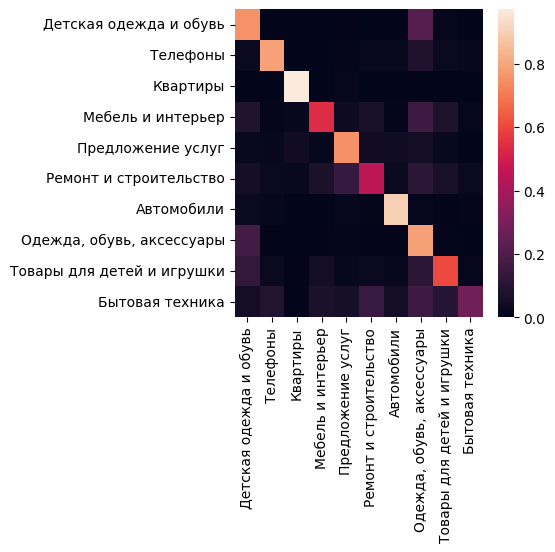

In [52]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_nmf_ETClf, xticklabels=metrics_nmf_ETClf.index.tolist()[:-1], 
            yticklabels=metrics_nmf_ETClf.index.tolist()[:-1])
plt.show()

In [53]:
metrics_svd_ETClf

precision  precision_std  recall  recall_std  \
Детская одежда и обувь           0.43           0.02    0.71        0.03   
Телефоны                         0.90           0.03    0.34        0.02   
Квартиры                         0.71           0.05    0.80        0.04   
Мебель и интерьер                0.76           0.08    0.13        0.02   
Предложение услуг                0.81           0.06    0.26        0.06   
Ремонт и строительство           0.67           0.11    0.10        0.02   
Автомобили                       0.82           0.04    0.47        0.06   
Одежда, обувь, аксессуары        0.46           0.01    0.70        0.03   
Товары для детей и игрушки       0.63           0.12    0.15        0.04   
Бытовая техника                  0.58           0.18    0.12        0.02   
mean                             0.68           0.07    0.38        0.03   

                              f1  f1_std  
Детская одежда и обувь      0.54    0.02  
Телефоны                    0.49    0.02  
Квартиры                    0.75    0.04  
Мебель и интерьер           0.21    0.03  
Предложение услуг           0.39    0.08  
Ремонт и строительство      0.18    0.04  
Автомобили                  0.59    0.06  
Одежда, обувь, аксессуары   0.56    0.01  
Товары для детей и игрушки  0.24    0.06  
Бытовая техника             0.20    0.03  
mean                        0.42    0.04

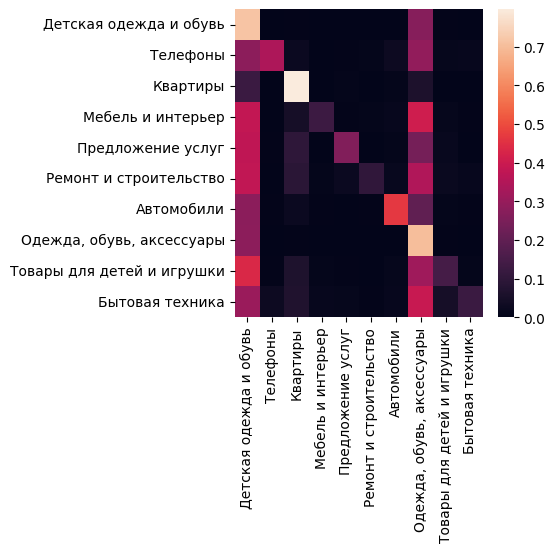

In [54]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_svd_ETClf, xticklabels=metrics_svd_ETClf.index.tolist()[:-1], 
            yticklabels=metrics_svd_ETClf.index.tolist()[:-1])
plt.show()

#### Ответ

Лучше всего выглядят SGDClassifier с SVD и ExtraTreesClassifier с NMF.

Но можно было бы ещё параметры классификаторов поподбирать (я брала самы базовые из примеров sklearn). Но тогда бы очень много времени ушло.

### Задание № 2 (6 баллов)

В Gensim тоже можно добавить нграммы и tfidf. Постройте 1 модель без них (как в семинаре) и еще 3 модели (1 с нграммами, 1 с tfidf и 1 с нграммами и с tfidf). Сранивните качество с помощью метрик (перплексия, когерентность) и на глаз. Определите лучшую модель. Для каждой модели выберите 1 самую красивую на ваш взгляд тему.

Используйте данные википедии из семинара. Можете взять поменьше данных, если все обучается долго.

Важное требование - получившиеся модели не должны быть совсем плохими. Если хороших тем не получается, попробуйте настроить гиперпараметры, отфильтровать словарь по-другому. 

Нграммы добавляются вот так (перед созданием словаря)

In [2]:
texts = [text.split() for text in texts]
ph = gensim.models.Phrases(texts, scoring='npmi', threshold=0.4) # threshold можно подбирать
p = gensim.models.phrases.Phraser(ph)
ngrammed_texts = p[texts] 

# ! не забудьте, что далее вам нужно будет использовать ngrammed_texts

!! В модели с нграммами вначале посмотрите, что получается после преобразования
Если вы выведите несколько первых текстов в ngrammed_texts, то там должно быть что-то такое:

In [7]:
[text for text in ngrammed_texts[:3]]
>> [['новостройка',
  'нижегородский_область', # нграм
  'новостро́йка',
  '—',
  'сельский',
  'посёлок',
  'в',
  'дивеевский_район', # нграм
  'нижегородский_область', #нграмм
  'входить',
  'в',
  'состав_сатисский', #нграмм
  'сельсовет',
  'посёлок',
  'расположить',
  'в',
  '12,5',
  'километр',
....

Если вы не видите нграммов, то попробуйте изменить параметр threshold

Tfidf добавляется вот так (после векторизации и перед обучением lda)

In [4]:
tfidf = gensim.models.TfidfModel(corpus, id2word=dictionary, )
corpus = tfidf[corpus]

### Просто модель

In [83]:
texts_w = open('wiki_data.txt').read().splitlines()[:2500]
texts = ([normalize(text) for text in texts_w])

In [84]:
dictinary = gensim.corpora.Dictionary((text.split() for text in texts))

In [64]:
dictinary.filter_extremes(no_above=0.1, no_below=10)
dictinary.compactify()

In [65]:
corpus = [dictinary.doc2bow(text.split()) for text in texts]

In [66]:
lda = gensim.models.LdaModel(corpus, 200, id2word=dictinary, passes=5)

In [67]:
lda.print_topics()

[(198,
  '0.198*"1968" + 0.129*"мексика" + 0.078*"мехико" + 0.067*"двенадцатый" + 0.047*"1949" + 0.039*"мужчина" + 0.030*"мужской" + 0.024*"люксембург" + 0.022*"состоять" + 0.015*"григорий"'),
 (186,
  '0.079*"князь" + 0.057*"великий" + 0.053*"дмитрий" + 0.048*"василий" + 0.036*"василиевич" + 0.027*"украинский" + 0.020*"княгиня" + 0.018*"иван" + 0.018*"дмитриевич" + 0.014*"фёдор"'),
 (2,
  '0.056*"1976" + 0.035*"1-й" + 0.027*"слава" + 0.027*"ссср" + 0.027*"международный" + 0.025*"пл" + 0.022*"центральный" + 0.018*"2-й" + 0.016*"21" + 0.016*"доска"'),
 (103,
  '0.014*"мир" + 0.011*"мировой" + 0.009*"глава" + 0.009*"движение" + 0.008*"немецкий" + 0.008*"сила" + 0.008*"арестовать" + 0.007*"создание" + 0.007*"операция" + 0.007*"вестись"'),
 (191,
  '0.011*"чтобы" + 0.011*"я" + 0.008*"бы" + 0.008*"мир" + 0.008*"смочь" + 0.006*"ребёнок" + 0.006*"уже" + 0.006*"найти" + 0.006*"удаться" + 0.006*"вместе"'),
 (125,
  '0.080*"фильм" + 0.044*"роль" + 0.014*"режиссёр" + 0.014*"актёр" + 0.012*"театр"

#### Вот, например, понятная:

0.080*"фильм" + 0.044*"роль" + 0.014*"режиссёр" + 0.014*"актёр" + 0.012*"театр" + 0.011*"актриса" + 0.011*"сцена" + 0.011*"кино" + 0.010*"сериал" + 0.009*"главный"

In [68]:
pyLDAvis.enable_notebook()

In [69]:
pyLDAvis.gensim_models.prepare(lda, corpus, dictinary)

/usr/local/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
59    -0.107504 -0.015495       1        1  5.140898
191   -0.076672  0.200618       2        1  4.196314
24    -0.102604  0.232801       3        1  2.508868
78    -0.120503  0.073122       4        1  2.076658
47    -0.083665  0.156378       5        1  2.029638
...         ...       ...     ...      ...       ...
162    0.201641  0.024511     196        1  0.032724
20     0.210436  0.012259     197        1  0.032318
56     0.211593  0.028824     198        1  0.024630
95     0.212885 -0.003641     199        1  0.020105
156    0.226123  0.044635     200        1  0.008904

[200 rows x 5 columns], topic_info=             Term        Freq       Total  Category  logprob  loglift
104        остров  496.000000  496.000000   Default  30.0000  30.0000
63           река  504.000000  504.000000   Default  29.0000  29.0000
1207            г  849.000000  849.000000   Default  28.0000  28.0000
638             5  361.000000  361.000000   Default  27.0000  27.0000
1784         ссср  526.000000  526.000000   Default  26.0000  26.0000
...           ...         ...         ...       ...      ...      ...
341          сила    0.008064  320.748594  Topic200  -7.9946  -1.2646
3              14    0.007886  208.092199  Topic200  -8.0169  -0.8542
1082  участвовать    0.007902  246.593120  Topic200  -8.0149  -1.0220
1264       победа    0.007929  302.315009  Topic200  -8.0115  -1.2223
39             км    0.007957  442.712200  Topic200  -8.0080  -1.6002

[8878 rows x 6 columns], token_table=      Topic      Freq Term
term                      
619      38  0.241263    0
619      65  0.051699    0
619      79  0.017233    0
619     119  0.568692    0
619     134  0.086165    0
...     ...       ...  ...
470      91  0.009933    №
470      98  0.003311    №
470     134  0.006622    №
470     164  0.019866    №
470     167  0.029799    №

[31137 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[60, 192, 25, 79, 48, 126, 152, 27, 111, 61, 6, 87, 104, 63, 38, 81, 77, 136, 90, 191, 154, 18, 130, 83, 67, 189, 59, 129, 107, 106, 170, 113, 7, 17, 93, 32, 150, 165, 132, 55, 196, 92, 143, 70, 103, 49, 188, 171, 148, 43, 161, 98, 187, 78, 166, 121, 91, 66, 122, 160, 100, 30, 128, 51, 101, 137, 97, 10, 127, 138, 169, 183, 47, 114, 109, 44, 144, 200, 86, 26, 68, 3, 73, 155, 84, 112, 193, 117, 8, 197, 174, 168, 190, 156, 16, 147, 184, 135, 185, 140, 178, 14, 134, 41, 194, 146, 162, 12, 80, 116, 54, 131, 52, 85, 35, 139, 20, 50, 28, 105, 102, 42, 56, 2, 115, 153, 95, 58, 1, 124, 141, 76, 24, 34, 181, 13, 45, 64, 4, 142, 11, 23, 179, 74, 31, 198, 119, 40, 120, 118, 75, 175, 19, 110, 151, 15, 94, 22, 149, 89, 180, 159, 39, 182, 173, 88, 125, 72, 145, 29, 36, 9, 176, 177, 5, 172, 46, 167, 62, 195, 158, 65, 69, 133, 164, 123, 199, 33, 53, 108, 186, 99, 37, 82, 71, 163, 21, 57, 96, 157])

In [70]:
np.exp2(-lda.log_perplexity(corpus[:1000]))

574.9842218945284

In [71]:
topics = []
for topic_id, topic in lda.show_topics(num_topics=100, formatted=False):
    topic = [word for word, _ in topic]
    topics.append(topic)

In [72]:
coherence_model_lda = gensim.models.CoherenceModel(topics=topics, 
                                                   texts=[text.split() for text in texts], 
                                                   dictionary=dictinary, coherence='c_v')

In [73]:
coherence_model_lda.get_coherence()

0.44682800040509385

### С нграммами

In [74]:
texts = [text.split() for text in texts]
ph = gensim.models.Phrases(texts, scoring='npmi', threshold=0.4) # threshold можно подбирать
p = gensim.models.phrases.Phraser(ph)
ngrammed_texts = p[texts]

In [93]:
# [text for text in ngrammed_texts[:3]]

In [94]:
dictinary = gensim.corpora.Dictionary((text for text in ngrammed_texts))

In [95]:
dictinary.filter_extremes(no_above=0.1, no_below=10)
dictinary.compactify()

In [97]:
corpus = [dictinary.doc2bow(text) for text in ngrammed_texts]

In [98]:
lda = gensim.models.LdaModel(corpus, 200, id2word=dictinary, passes=5)

In [99]:
lda.print_topics()

[(127,
  '0.116*"посол" + 0.072*"россия" + 0.054*"официальный" + 0.050*"резиденция" + 0.050*"1850" + 0.031*"писать" + 0.029*"1918_год" + 0.023*"правление" + 0.022*"экспедиция" + 0.021*"экипаж"'),
 (53,
  '0.058*"фильм" + 0.032*"доктор" + 0.020*"жить" + 0.019*"я" + 0.015*"режиссёр" + 0.014*"книга" + 0.010*"человеческий" + 0.009*"хороший" + 0.009*"сценарий" + 0.008*"картина"'),
 (52,
  '0.133*"попельнянский_район" + 0.100*"попельнянский_р-н" + 0.088*"—_4137" + 0.058*"село" + 0.043*"юго-восток" + 0.043*"ул_ленин" + 0.035*"северо-запад" + 0.035*"районный_центр" + 0.034*"юго-запад" + 0.034*"юг"'),
 (0,
  '0.107*"молодой" + 0.066*"бог" + 0.034*"обыкновенный" + 0.034*"мифология" + 0.034*"зверь" + 0.034*"земля" + 0.030*"создатель" + 0.028*"дикий" + 0.027*"небо" + 0.025*"медведь"'),
 (120,
  '0.100*"россия" + 0.080*"посольство" + 0.062*"бельгия" + 0.059*"зуб" + 0.049*"москва" + 0.037*"женщина" + 0.028*"бельгийский" + 0.022*"65" + 0.019*"лев" + 0.018*"всегда"'),
 (122,
  '0.066*"олимпийский_игра

#### Мне нравится:
Например,

0.107*"молодой" + 0.066*"бог" + 0.034*"обыкновенный" + 0.034*"мифология" + 0.034*"зверь" + 0.034*"земля" + 0.030*"создатель" + 0.028*"дикий" + 0.027*"небо" + 0.025*"медведь"

0.066*"олимпийский_игра" + 0.063*"на_летний" + 0.062*"спортсмен" + 0.055*"соревнование_по" + 0.046*"летний_олимпийский" + 0.033*"медаль_сборная" + 0.023*"плавание" + 0.023*"женщина" + 0.022*"следующий_раунд" + 0.021*"мужчина"

In [100]:
pyLDAvis.gensim_models.prepare(lda, corpus, dictinary)

/usr/local/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
70     0.103409 -0.126213       1        1  3.986497
37     0.105622 -0.224287       2        1  3.788589
119    0.107435 -0.142806       3        1  3.067512
27     0.100839 -0.186695       4        1  3.010797
71     0.092893 -0.143352       5        1  2.729448
...         ...       ...     ...      ...       ...
59    -0.211516 -0.079997     196        1  0.016942
187   -0.222825 -0.117642     197        1  0.005210
15    -0.220770 -0.119001     198        1  0.005210
25    -0.226667 -0.116159     199        1  0.005210
85    -0.223577 -0.117200     200        1  0.005210

[200 rows x 5 columns], topic_info=                   Term        Freq       Total  Category  logprob  loglift
1216                  г  835.000000  835.000000   Default  30.0000  30.0000
1177               село  682.000000  682.000000   Default  29.0000  29.0000
211                игра  425.000000  425.000000   Default  28.0000  28.0000
97               остров  350.000000  350.000000   Default  27.0000  27.0000
89                фильм  435.000000  435.000000   Default  26.0000  26.0000
...                 ...         ...         ...       ...      ...      ...
678             военный    0.003850  242.978669  Topic200  -8.1173  -1.1905
180               выйти    0.003850  253.999827  Topic200  -8.1172  -1.2347
1007  принимать_участие    0.003797  168.650934  Topic200  -8.1310  -0.8391
2476               июль    0.003843  315.889934  Topic200  -8.1189  -1.4545
1648              школа    0.003785  350.599753  Topic200  -8.1343  -1.5742

[8861 rows x 6 columns], token_table=      Topic      Freq Term
term                      
613       3  0.017016    0
613      45  0.153144    0
613      68  0.680638    0
613     133  0.119112    0
4805      3  0.462941  0,5
...     ...       ...  ...
2630     20  0.245992  №_1
2630     21  0.553481  №_1
2630     66  0.030749  №_1
3591     18  0.798665  №_2
3591     27  0.114095  №_2

[31811 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[71, 38, 120, 28, 72, 99, 156, 149, 54, 4, 73, 137, 84, 98, 159, 122, 135, 12, 193, 40, 44, 147, 105, 2, 151, 27, 51, 142, 97, 170, 129, 14, 87, 184, 107, 109, 113, 62, 24, 186, 13, 39, 197, 190, 36, 55, 173, 175, 47, 187, 48, 35, 6, 7, 180, 93, 103, 82, 41, 131, 183, 104, 123, 56, 127, 50, 21, 64, 31, 154, 194, 70, 198, 199, 108, 181, 200, 81, 25, 164, 110, 117, 19, 185, 69, 3, 80, 101, 189, 17, 168, 177, 179, 115, 88, 83, 42, 126, 166, 85, 152, 176, 90, 158, 134, 121, 43, 102, 125, 66, 116, 77, 182, 30, 32, 124, 133, 167, 57, 58, 96, 153, 52, 53, 157, 5, 22, 138, 192, 169, 67, 1, 100, 178, 162, 29, 78, 23, 8, 94, 114, 68, 191, 15, 9, 165, 130, 171, 118, 61, 75, 148, 49, 79, 119, 143, 195, 106, 160, 128, 46, 91, 146, 95, 10, 33, 140, 45, 144, 37, 20, 174, 65, 11, 161, 112, 76, 136, 34, 172, 163, 155, 141, 74, 63, 18, 59, 89, 111, 196, 150, 132, 139, 145, 92, 60, 188, 16, 26, 86])

In [101]:
np.exp2(-lda.log_perplexity(corpus[:1000]))

769.9997962337968

In [102]:
topics = []
for topic_id, topic in lda.show_topics(num_topics=100, formatted=False):
    topic = [word for word, _ in topic]
    topics.append(topic)

In [103]:
coherence_model_lda = gensim.models.CoherenceModel(topics=topics, 
                                                   texts=[text for text in ngrammed_texts], 
                                                   dictionary=dictinary, coherence='c_v')

In [104]:
coherence_model_lda.get_coherence()

0.4349386251915007

### С tfidf

In [180]:
texts = ([normalize(text) for text in texts_w])

In [181]:
dictinary = gensim.corpora.Dictionary((text.split() for text in texts))

In [182]:
dictinary.filter_extremes(no_above=0.1, no_below=10)
dictinary.compactify()

In [183]:
corpus = [dictinary.doc2bow(text.split()) for text in texts]

In [184]:
tfidf = gensim.models.TfidfModel(corpus, id2word=dictinary,)
corpus = tfidf[corpus]

In [185]:
lda = gensim.models.LdaModel(corpus, 90, id2word=dictinary, passes=5)

In [186]:
lda.print_topics()

[(72,
  '0.091*"телефон" + 0.032*"футбол" + 0.029*"казахстан" + 0.024*"внутренний" + 0.022*"особняк" + 0.020*"устройство" + 0.018*"хребет" + 0.017*"камера" + 0.015*"присутствовать" + 0.015*"сырьё"'),
 (19,
  '0.018*"делегация" + 0.013*"переговоры" + 0.000*"ссср" + 0.000*"министр" + 0.000*"правительство" + 0.000*"роль" + 0.000*"иностранный" + 0.000*"положение" + 0.000*"чемпион" + 0.000*"1971"'),
 (54,
  '0.116*"переименовать" + 0.045*"камень" + 0.035*"памятник" + 0.024*"1940" + 0.023*"впадение" + 0.017*"архитектура" + 0.011*"культура" + 0.008*"находить" + 0.008*"правило" + 0.008*"родный"'),
 (32,
  '0.016*"команда" + 0.013*"сезон" + 0.013*"8" + 0.012*"15" + 0.011*"август" + 0.011*"июль" + 0.011*"март" + 0.010*"клуб" + 0.010*"1972" + 0.010*"играть"'),
 (69,
  '0.023*"сергей" + 0.023*"1944" + 0.021*"младший" + 0.020*"наградить" + 0.020*"танковый" + 0.020*"дивизия" + 0.018*"лейтенант" + 0.016*"адольф" + 0.015*"кавалер" + 0.015*"щит"'),
 (52,
  '0.077*"35" + 0.061*"победа" + 0.026*"дисципли

#### Мне нравится, например:

0.066*"матч" + 0.051*"клуб" + 0.050*"кубок" + 0.037*"чемпионат" + 0.023*"32" + 0.020*"португалия" + 0.019*"лига" + 0.018*"против" + 0.018*"чемпион" + 0.018*"провести"

In [187]:
pyLDAvis.gensim_models.prepare(lda, corpus, dictinary)

/usr/local/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
59    -0.228557  0.244381       1        1  10.111082
20    -0.235756 -0.091806       2        1   8.791875
32    -0.251458 -0.166481       3        1   7.562438
26    -0.209498  0.114841       4        1   4.969688
29    -0.207707  0.139235       5        1   4.923001
...         ...       ...     ...      ...        ...
37     0.028421  0.000047      86        1   0.239933
38     0.027358  0.000276      87        1   0.232175
24     0.027647  0.000061      88        1   0.232175
21     0.027648  0.000143      89        1   0.232175
89     0.027637  0.000208      90        1   0.232175

[90 rows x 5 columns], topic_info=               Term       Freq      Total Category  logprob  loglift
4551    романовский  59.000000  59.000000  Default  30.0000  30.0000
4557  попельнянский  47.000000  47.000000  Default  29.0000  29.0000
2840          ленин  31.000000  31.000000  Default  28.0000  28.0000
96            фильм  30.000000  30.000000  Default  27.0000  27.0000
2622         летний  44.000000  44.000000  Default  26.0000  26.0000
...             ...        ...        ...      ...      ...      ...
2                12   0.006937  13.006256  Topic90  -8.3985  -1.4709
39               км   0.006935  24.343147  Topic90  -8.3988  -2.0980
3035    влиятельный   0.006930   2.550515  Topic90  -8.3996   0.1572
218           земля   0.006929  15.511526  Topic90  -8.3996  -1.6481
1206            xix   0.006923   7.617467  Topic90  -8.4005  -0.9379

[4087 rows x 6 columns], token_table=      Topic      Freq Term
term                      
619      74  0.624967    0
0        29  0.781021  1,2
1        32  0.915505  1,5
4440     29  0.748188  1,8
1003      9  0.299980  1-й
...     ...       ...  ...
3713     38  0.702544    “
3714     38  0.737307    „
470       2  0.344437    №
470       3  0.275550    №
470       4  0.275550    №

[2677 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[60, 21, 33, 27, 30, 47, 63, 24, 31, 11, 78, 26, 9, 71, 13, 41, 23, 10, 28, 6, 66, 17, 87, 65, 70, 36, 49, 58, 8, 53, 35, 64, 34, 16, 43, 48, 44, 68, 81, 37, 76, 88, 12, 89, 55, 19, 57, 54, 7, 73, 18, 1, 56, 67, 42, 3, 4, 85, 79, 50, 59, 69, 86, 84, 52, 5, 82, 29, 51, 14, 75, 80, 15, 61, 62, 45, 2, 32, 46, 72, 40, 77, 74, 83, 20, 38, 39, 25, 22, 90])

In [189]:
np.exp2(-lda.log_perplexity(corpus[:1000]))

2000948337092.0474

In [190]:
topics = []
for topic_id, topic in lda.show_topics(num_topics=100, formatted=False):
    topic = [word for word, _ in topic]
    topics.append(topic)

In [191]:
coherence_model_lda = gensim.models.CoherenceModel(topics=topics, 
                                                   texts=[text.split() for text in texts], 
                                                   dictionary=dictinary, coherence='c_v')

In [192]:
coherence_model_lda.get_coherence()

0.38470954024994225

### С нграммами и tfidf

In [199]:
dictinary = gensim.corpora.Dictionary((text for text in ngrammed_texts))

In [200]:
dictinary.filter_extremes(no_above=0.1, no_below=10)
dictinary.compactify()

In [201]:
corpus = [dictinary.doc2bow(text) for text in ngrammed_texts]

In [202]:
tfidf = gensim.models.TfidfModel(corpus, id2word=dictinary,)
corpus = tfidf[corpus]

In [211]:
lda = gensim.models.LdaModel(corpus, 85, id2word=dictinary, passes=5)

In [212]:
lda.print_topics()

[(49,
  '0.082*"фамилия" + 0.071*"река" + 0.037*"впадать" + 0.023*"бассейн" + 0.021*"1875" + 0.020*"долина" + 0.018*"км" + 0.018*"трасса" + 0.017*"гора" + 0.014*"длина"'),
 (25,
  '0.035*"иван" + 0.020*"принцесса" + 0.014*"свадьба" + 0.000*"альбом" + 0.000*"сергей" + 0.000*"стекло" + 0.000*"звезда" + 0.000*"маленький" + 0.000*"роман" + 0.000*"завершить"'),
 (46,
  '0.039*"34" + 0.025*"полуфинал" + 0.021*"прыжок" + 0.020*"андрей" + 0.019*"константин" + 0.011*"предварительный" + 0.001*"жена" + 0.001*"род" + 0.000*"четыре" + 0.000*"спустя"'),
 (37,
  '0.014*"французский" + 0.012*"друг" + 0.010*"игра" + 0.010*"брак" + 0.010*"право" + 0.010*"китай" + 0.010*"король" + 0.010*"вал" + 0.009*"вблизи" + 0.008*"фёдор"'),
 (29,
  '0.085*"46" + 0.032*"зелёный" + 0.029*"кнр" + 0.025*"высокий" + 0.018*"село" + 0.018*"авиакомпания" + 0.017*"двор" + 0.011*"речка" + 0.005*"купить" + 0.005*"стан"'),
 (51,
  '0.016*"дэвис" + 0.006*"турнир" + 0.006*"2003_год" + 0.001*"бюро" + 0.000*"финал" + 0.000*"студия" 

#### Темы не очень

Вот эта понятная:

0.077*"дивизия" + 0.040*"стрелковый_дивизия" + 0.014*"рубеж" + 0.009*"северо-восточный" + 0.006*"окружение" + 0.006*"корпус" + 0.003*"наступать" + 0.003*"сентябрь_1941" + 0.002*"пехотный_дивизия" + 0.002*"отступить"

In [214]:
pyLDAvis.gensim_models.prepare(lda, corpus, dictinary)

/usr/local/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12    -0.238816 -0.347559       1        1  18.497540
76    -0.269821  0.166870       2        1   7.446975
55    -0.249072  0.007757       3        1   7.381151
37    -0.138152  0.095790       4        1   3.906188
84    -0.119534  0.047641       5        1   3.788620
...         ...       ...     ...      ...        ...
38     0.017261 -0.002020      81        1   0.273452
7      0.018650 -0.001345      82        1   0.268595
51     0.017919 -0.000397      83        1   0.262655
15     0.015017 -0.001884      84        1   0.255456
82     0.015212 -0.001796      85        1   0.255456

[85 rows x 5 columns], topic_info=                     Term       Freq      Total Category  logprob  loglift
1668                   ул  47.000000  47.000000  Default  30.0000  30.0000
1177                 село  64.000000  64.000000  Default  29.0000  29.0000
291               площадь  29.000000  29.000000  Default  28.0000  28.0000
5031  попельнянский_район  30.000000  30.000000  Default  27.0000  27.0000
1216                    г  28.000000  28.000000  Default  26.0000  26.0000
...                   ...        ...        ...      ...      ...      ...
3243              влияние   0.007296   5.107264  Topic85  -8.4906  -0.5812
1956             движение   0.007291   7.006584  Topic85  -8.4913  -0.8981
3813            противник   0.007290   8.082508  Topic85  -8.4915  -1.0411
1840                лидер   0.007289   3.680826  Topic85  -8.4916  -0.2546
1573        строительство   0.007287   4.306318  Topic85  -8.4920  -0.4119

[3804 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
613      13  0.771603       0
614      23  0.468254     000
0        40  0.442514     1,2
1         8  0.737702  1,5_км
4878     40  0.831894     1,8
...     ...       ...     ...
77        3  0.276183       …
463       8  0.541700       №
463      12  0.216680       №
463      18  0.108340       №
463      26  0.108340       №

[2617 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 77, 56, 38, 85, 58, 27, 51, 14, 55, 3, 68, 73, 43, 33, 37, 67, 4, 25, 18, 21, 65, 81, 53, 69, 61, 45, 15, 35, 44, 7, 28, 74, 17, 75, 36, 79, 50, 48, 41, 57, 10, 24, 12, 63, 84, 30, 59, 2, 22, 5, 78, 62, 76, 6, 19, 72, 32, 47, 34, 70, 49, 64, 20, 29, 40, 31, 60, 1, 23, 71, 80, 54, 11, 66, 82, 9, 46, 42, 26, 39, 8, 52, 16, 83])

In [216]:
np.exp2(-lda.log_perplexity(corpus[:1000]))

6027282558270.0625

In [217]:
topics = []
for topic_id, topic in lda.show_topics(num_topics=100, formatted=False):
    topic = [word for word, _ in topic]
    topics.append(topic)

In [218]:
coherence_model_lda = gensim.models.CoherenceModel(topics=topics, 
                                                   texts=[text for text in ngrammed_texts], 
                                                   dictionary=dictinary, coherence='c_v')

In [219]:
coherence_model_lda.get_coherence()

0.37117383832302603

Комментарий про код. Да, можно было сохранить нормализованные данные не в texts, а в разные специальные переменные, тогда бы не пришлось нормализовывать больше двух раз.

Перплексия ужасная получилась. Но темы терпимые. Чтобы улучшить, можно было бы побольше текстов взять. И ещё поподбирать.

Больше всего мне нравится результат "просто модели" и модели с нграммами. И по словам, и по картинке, и по перплексии, и по когерентности.